In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [3]:
cnx = sqlite3.connect('../sales_db/data/sqlite.db')
# без сиропов
query = """SELECT * FROM v_sales
            WHERE ta_type = 'Кофейный ТА' AND ta_cell_number <= 90"""
sales = pd.read_sql_query(query, cnx)

In [4]:
sales.to_pickle('sales.pkl')

In [2]:
sales = pd.read_pickle('sales.pkl')

In [3]:
sales.doc_date = pd.to_datetime(sales.doc_date, dayfirst=True)

In [4]:
sales = sales[sales['division'].str.contains('ЦЕХ') == False]

In [5]:
sales.isnull().sum()

doc_number                      0
doc_date                        0
ta_serial                       0
ta_type                         0
division                        0
tt_name                         0
ta_cell_number                  0
product                       463
number_of_sales                 0
sum_of_sales                    0
product_cost_price              0
product_control_cost_price      0
dtype: int64

In [6]:
sales = sales[['doc_date', 'ta_serial', 'number_of_sales', 'sum_of_sales', 'product_control_cost_price']]

In [7]:
sales_grouped = sales.groupby('doc_date')

In [8]:
sales_days = sales_grouped.agg({"ta_serial": "nunique",
                   "number_of_sales": "sum",
                   "sum_of_sales": "sum",
                   "product_control_cost_price": "sum"})

In [9]:
sales_days = sales_days.reset_index()

In [10]:
sales_days['day_of_week'] = sales_days['doc_date'].dt.dayofweek

In [11]:
sales_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   doc_date                    1095 non-null   datetime64[ns]
 1   ta_serial                   1095 non-null   int64         
 2   number_of_sales             1095 non-null   int64         
 3   sum_of_sales                1095 non-null   int64         
 4   product_control_cost_price  1095 non-null   float64       
 5   day_of_week                 1095 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 47.2 KB


In [12]:
sales_days['d_m'] = sales_days.doc_date.dt.strftime('%d%m')

In [13]:
sales_days.head()

,doc_date,ta_serial,number_of_sales,sum_of_sales,product_control_cost_price,day_of_week,d_m
0,2021-01-01,171,1906,238338,53931.36,4,0101
1,2021-01-02,177,1999,241299,54787.48,5,0201
2,2021-01-03,170,2084,253415,57183.71,6,0301
3,2021-01-04,189,2325,280594,64282.21,0,0401
4,2021-01-05,190,2423,284135,64758.29,1,0501


array([[<Axes: title={'center': 'doc_date'}>,
        <Axes: title={'center': 'ta_serial'}>],
       [<Axes: title={'center': 'number_of_sales'}>,
        <Axes: title={'center': 'sum_of_sales'}>],
       [<Axes: title={'center': 'product_control_cost_price'}>,
        <Axes: title={'center': 'day_of_week'}>]], dtype=object)

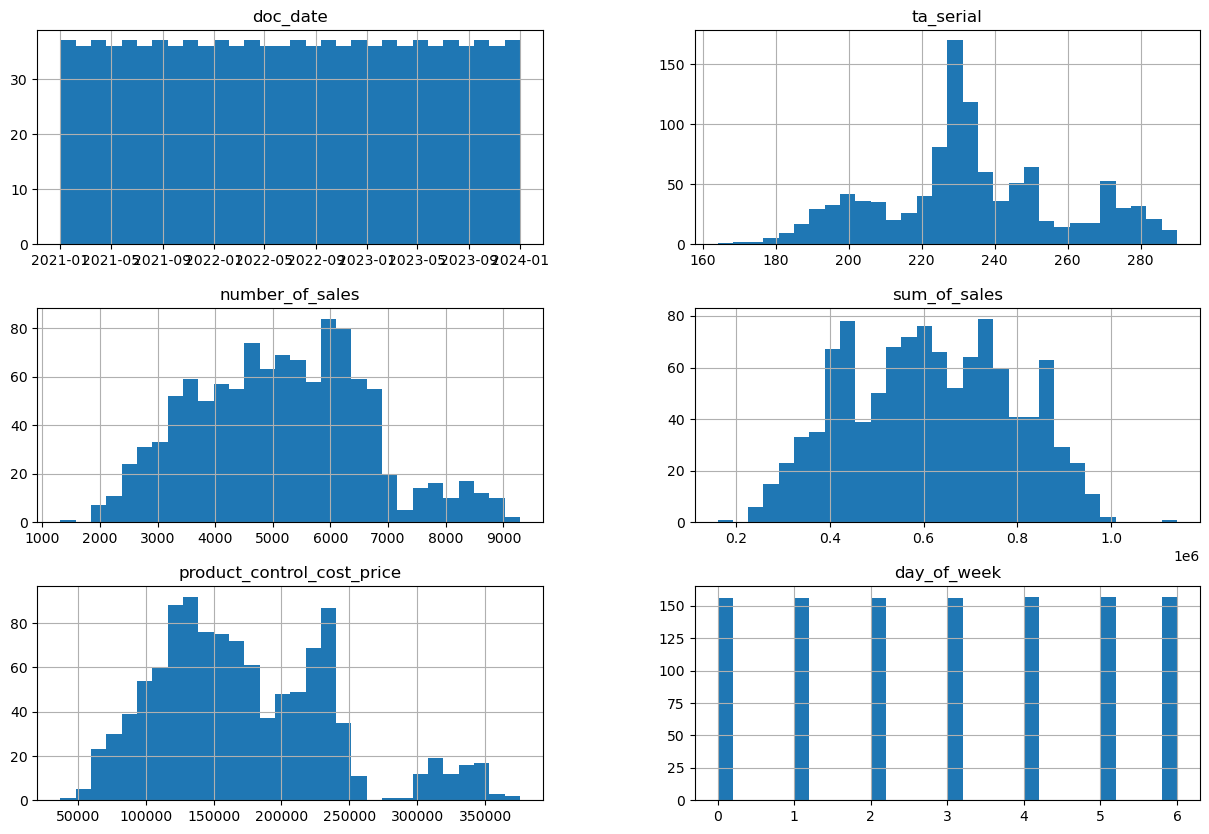

In [14]:
sales_days.hist(bins=30, figsize=(15, 10))

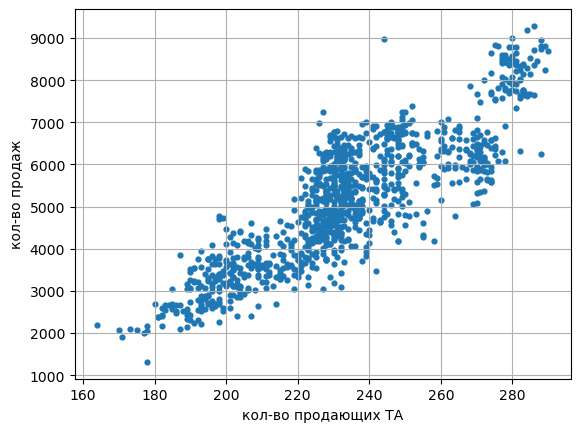

In [15]:
    xs = sales_days['ta_serial']
    ys = sales_days['number_of_sales']
    pd.DataFrame(np.array([xs,ys]).T).plot.scatter(0, 1, s=12, grid=True)
    plt.xlabel('кол-во продающих ТА')
    plt.ylabel('кол-во продаж')
    plt.show()

In [16]:
corr = sales_days.corr()

In [17]:
corr

,doc_date,ta_serial,number_of_sales,sum_of_sales,product_control_cost_price,day_of_week,d_m
doc_date,1.000000,0.662818,0.470593,0.410491,0.707107,0.001580,0.033010
ta_serial,0.662818,1.000000,0.858655,0.811835,0.899956,-0.416318,0.069733
number_of_sales,0.470593,0.858655,1.000000,0.978038,0.935841,-0.441489,0.082245
sum_of_sales,0.410491,0.811835,0.978038,1.000000,0.895015,-0.458962,0.087910
product_control_cost_price,0.707107,0.899956,0.935841,0.895015,1.000000,-0.338239,0.073589
day_of_week,0.001580,-0.416318,-0.441489,-0.458962,-0.338239,1.000000,-0.001775
d_m,0.033010,0.069733,0.082245,0.087910,0.073589,-0.001775,1.000000


In [18]:
X = sales_days[['doc_date', 'day_of_week', 'd_m']]
X['doc_date'] = X['doc_date'].values.astype('float64')
y = sales_days['sum_of_sales']

C:\Users\ms\AppData\Local\Temp\ipykernel_980\4116724319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['doc_date'] = X['doc_date'].values.astype('float64')


In [19]:
# импортируем необходимый модуль
from sklearn.model_selection import train_test_split
 
# размер тестовой выборки составит 30%
# также зададим точку отсчета для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [20]:
# из набора линейных моделей библиотеки sklearn импортируем линейную регрессию
from sklearn.linear_model import LinearRegression
 
# создадим объект этого класса и запишем в переменную model
model = LinearRegression()
 
# обучим нашу модель
model.fit(X_train, y_train)

C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spa

LinearRegression()

In [21]:
# на основе нескольких независимых переменных (Х) предскажем цену на жилье (y)
y_pred = model.predict(X_test)
 
# выведем первые пять значений с помощью диапазона индексов
print(y_pred[:5])

[620009.68941109 530299.60784024 537032.08585318 700583.27517458
 717855.7658543 ]


C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [22]:
# импортируем модуль метрик
from sklearn import metrics
 
# выведем корень среднеквадратической ошибки
# сравним тестовые и прогнозные значения цен на жилье
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error (RMSE): 163044.53615401857


C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [23]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

R2: 0.11


C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ms\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [42]:
X_train

,doc_date,day_of_week,d_m
636,1.664410e+18,3,2909
1041,1.699402e+18,2,0811
249,1.630973e+18,1,0709
706,1.670458e+18,3,0812
479,1.650845e+18,0,2504
...,...,...,...
330,1.637971e+18,5,2711
466,1.649722e+18,1,1204
121,1.619914e+18,6,0205
1044,1.699661e+18,5,1111


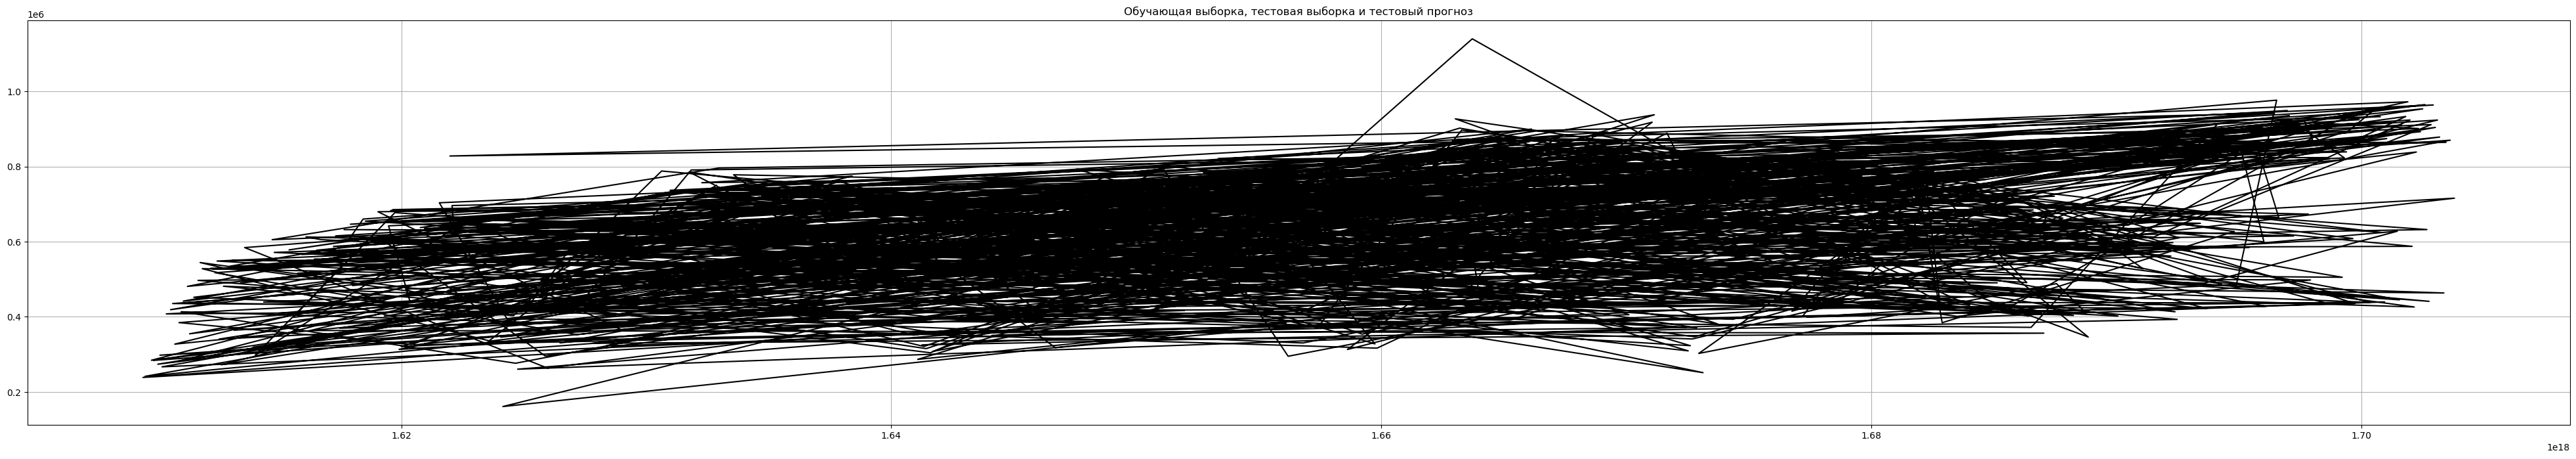

In [45]:
plt.figure(figsize=(50,8))
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(X_train['doc_date'], y_train, color = "black")
#plt.plot(y_test, color = "red")
#plt.plot(y_pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз") 
# добавим сетку
plt.grid()
 
plt.show()

In [21]:
sales_tseries = sales_days[['doc_date', 'day_of_week', 'd_m','sum_of_sales']]
sales_tseries.set_index('doc_date', inplace=True)

In [22]:
sales_tseries.head()

,day_of_week,d_m,sum_of_sales
doc_date,,,
2021-01-01,4,0101,234876
2021-01-02,5,0201,238737
2021-01-03,6,0301,250835
2021-01-04,0,0401,277606
2021-01-05,1,0501,281723


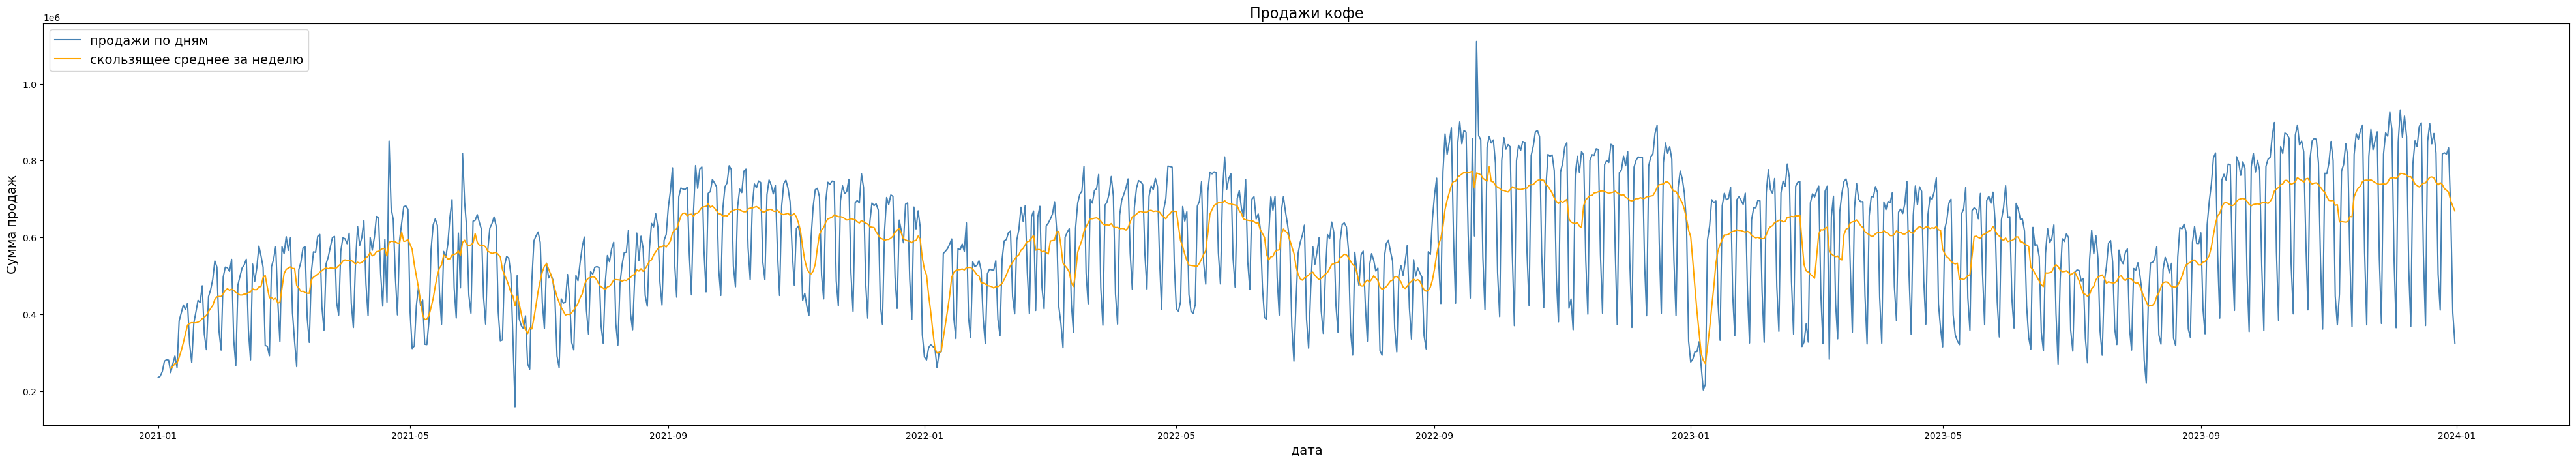

In [59]:
# зададим размер графика
plt.figure(figsize = (50,8))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(sales_tseries['sum_of_sales'], label = 'продажи по дням', color = 'steelblue')
plt.plot(sales_tseries['sum_of_sales'].rolling(window = 7).mean(), label = 'скользящее среднее за неделю', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('дата', fontsize = 14)
plt.ylabel('Сумма продаж', fontsize = 14)
plt.title('Продажи кофе', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()


Выявление компонентов временного ряда (time series decomposition) предполагает его разложение на тренд, сезонность и случайные колебания.

**Тренд** — долгосрочное изменение уровня ряда\
**Сезонность** предполагает циклические изменения уровня ряда с постоянным периодом\
**Случайные колебания** — непрогнозируемое случайное изменение ряда

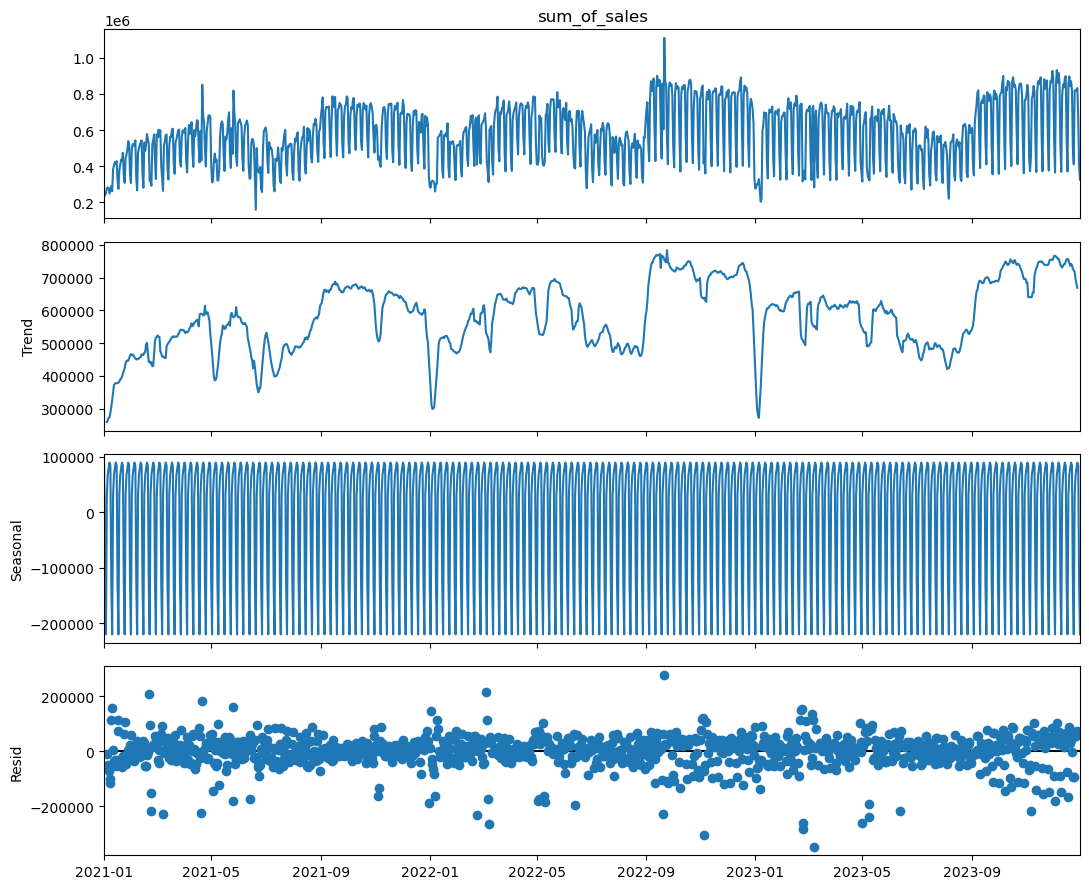

In [23]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(sales_tseries['sum_of_sales'])
decompose.plot()
 
plt.show()

Стационарность (stationarity) временного ряда как раз означает, что такие компоненты как тренд и сезонность отсутствуют. Говоря более точно, среднее значение и дисперсия не меняются со смещением во времени. Для более точной оценки стационарности можно применить тест Дики-Фуллера

In [24]:
# импортируем необходимую функцию 
from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(sales_tseries['sum_of_sales'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.008920037446783649


Результат существенно меньше 5%. Временной ряд стационарен.

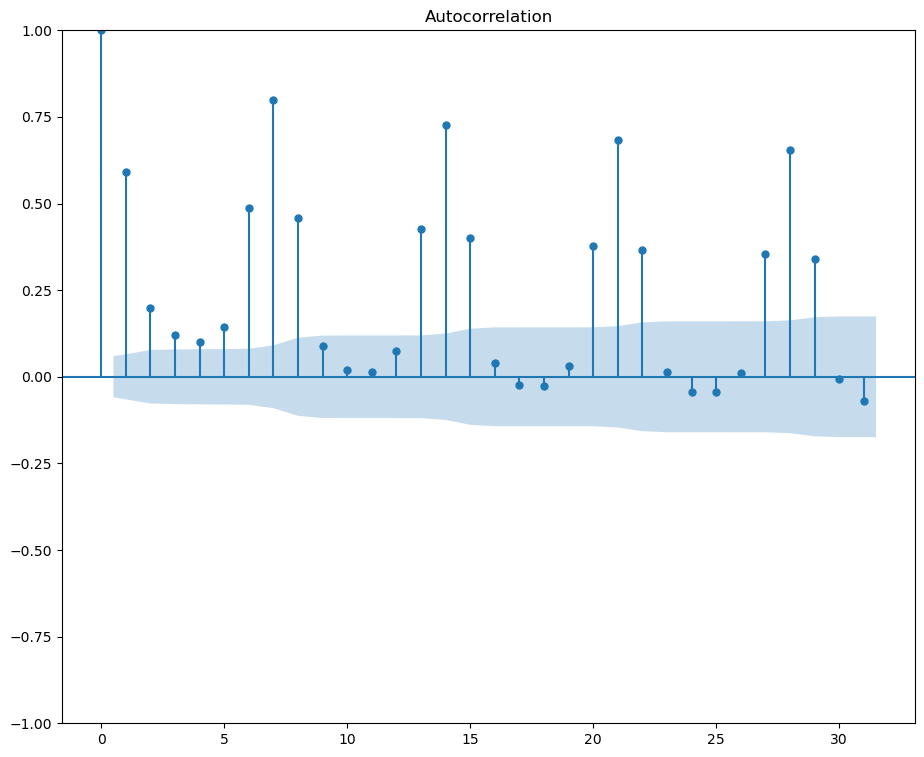

In [30]:
# импортируем функцию для построения автокорреляционной функции (ACF)
from statsmodels.graphics.tsaplots import plot_acf
 
# применим ее к данным о пассажирах
plot_acf(sales_tseries['sum_of_sales'])
plt.show()

In [25]:
sales_series = sales_tseries['sum_of_sales']

train = sales_series[:'2023-10-31']
test = sales_series['2023-11-01':]

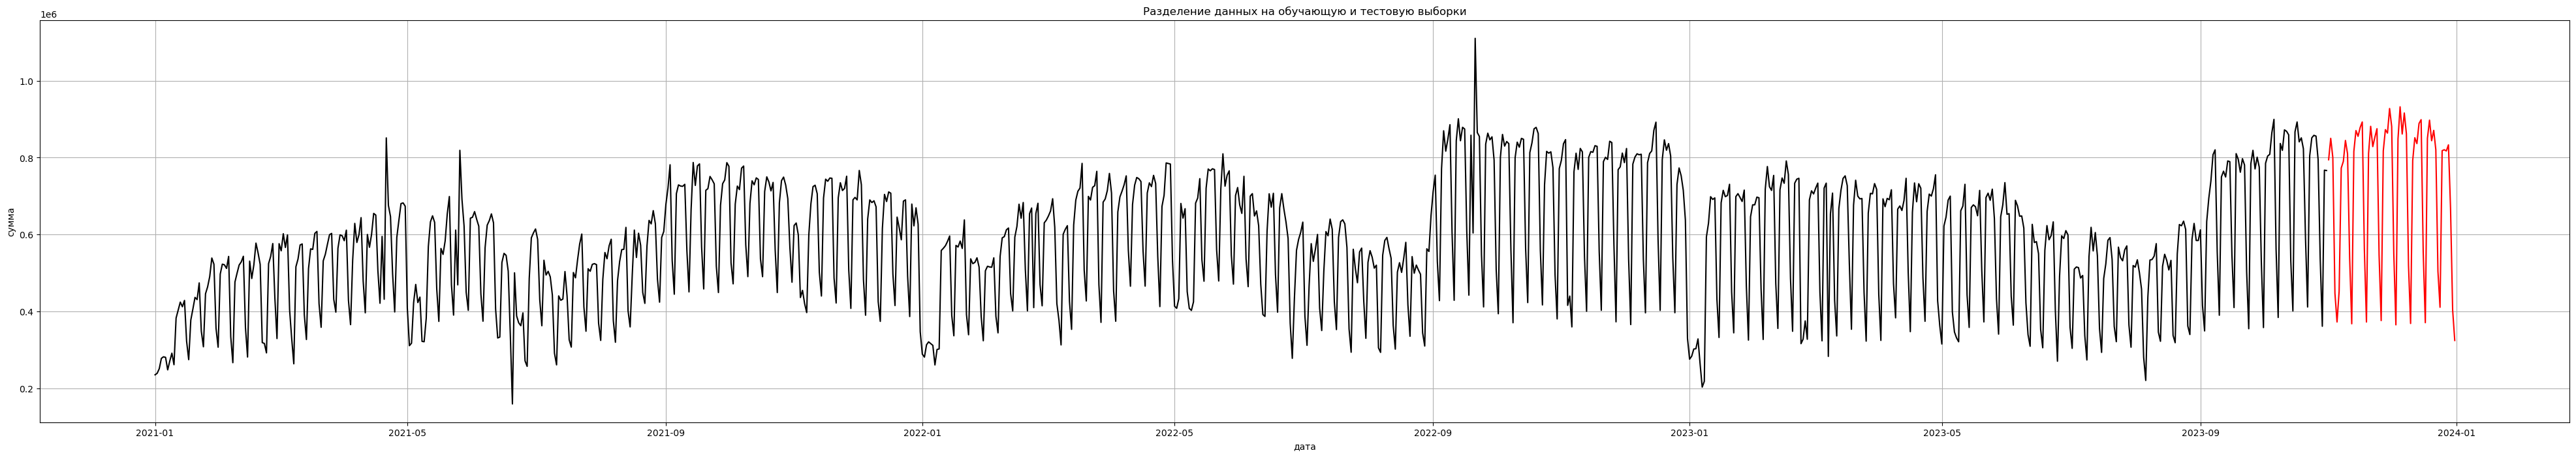

In [26]:
plt.figure(figsize=(50,8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('сумма')
plt.xlabel('дата')
 
# добавим сетку
plt.grid()
 
plt.show()

In [200]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 7)
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train, 
                order = (5, 1, 0), 
                seasonal_order = (1, 0, 0, 7))
 
# применим метод fit
result = model.fit()

In [201]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

2023-11-01    771678.052715
2023-11-02    775402.091969
2023-11-03    725876.194981
2023-11-04    520496.801836
2023-11-05    389628.325521
                  ...      
2023-12-27    520531.659992
2023-12-28    521027.278964
2023-12-29    514641.850726
2023-12-30    488447.002276
2023-12-31    471752.119327
Freq: D, Name: predicted_mean, Length: 61, dtype: float64

In [202]:
test

doc_date
2023-11-01    794400
2023-11-02    850085
2023-11-03    799995
2023-11-04    446960
2023-11-05    372265
               ...  
2023-12-27    817195
2023-12-28    833100
2023-12-29    667630
2023-12-30    403400
2023-12-31    324175
Name: sum_of_sales, Length: 61, dtype: int64

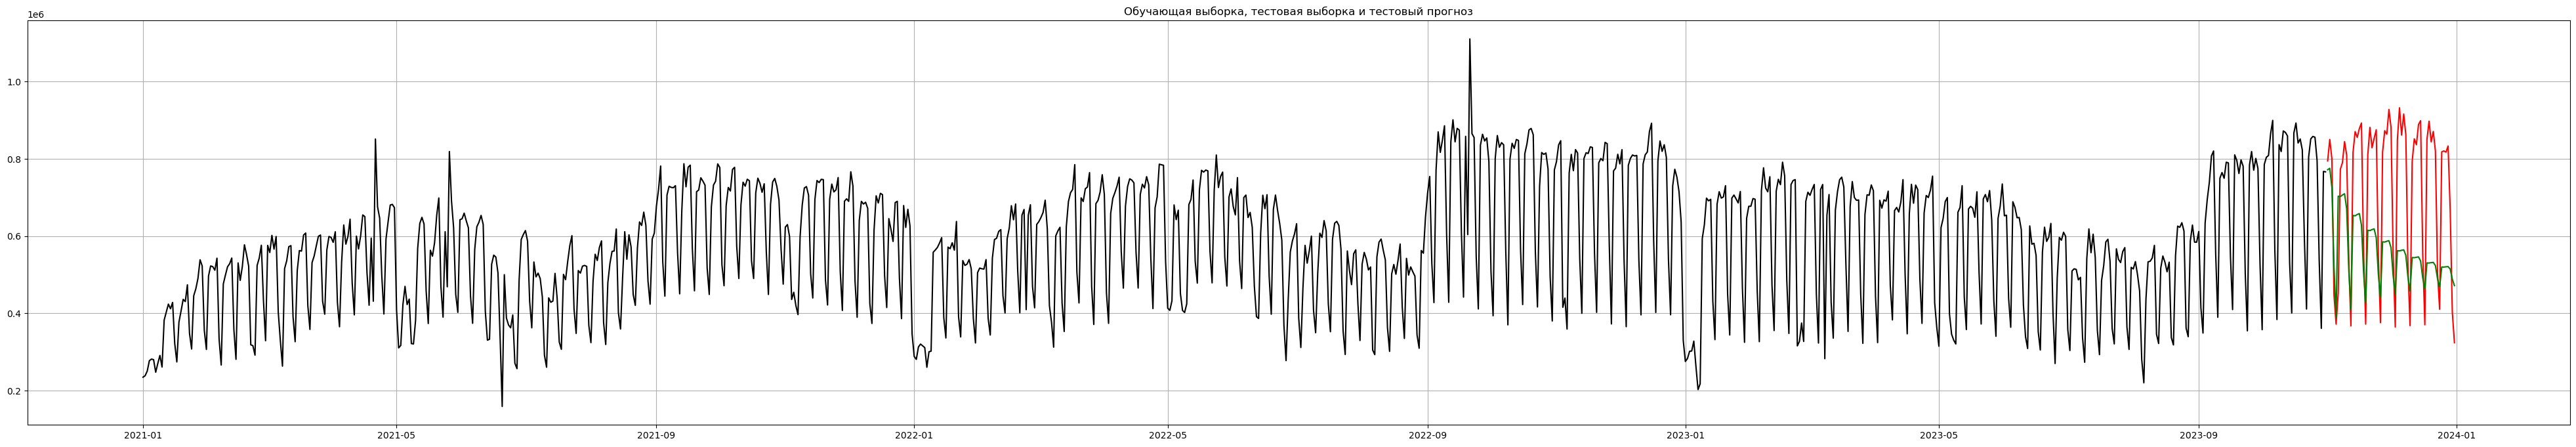

In [203]:
plt.figure(figsize=(50,8))
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз") 
# добавим сетку
plt.grid()
 
plt.show()

In [204]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test, predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

50776416263.42144
225336.22936274903


In [155]:
from pmdarima.arima import auto_arima

In [213]:
auto_model = auto_arima(sales_series,
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=12, max_q=12,
                      m=7,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None,
                      error_action='ignore',  
                      suppress_warnings=True)

In [214]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1095
Model:             SARIMAX(6, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -13806.374
Date:                           Wed, 24 Jan 2024   AIC                          27634.749
Time:                                   12:26:41   BIC                          27689.722
Sample:                               01-01-2021   HQIC                         27655.551
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1812.3877   1303.471      1.390      0.164    -742.368    4367.144
ar.L1         -1.3282      0.113    -11.703      0.000      -1.551      -1.106
ar.L2         -0.6464      0.063    -10.244      0.000      -0.770      -0.523
ar.L3         -0.4505      0.077     -5.860      0.000      -0.601      -0.300
ar.L4         -0.3040      0.083     -3.675      0.000      -0.466      -0.142
ar.L5         -0.2383      0.077     -3.075      0.002      -0.390      -0.086
ar.L6         -0.1247      0.046     -2.705      0.007      -0.215      -0.034
ma.L1          0.9427      0.113      8.329      0.000       0.721       1.165
ar.S.L7        0.9906      0.006    173.936      0.000       0.979       1.002
ma.S.L7       -0.8183      0.034    -24.233      0.000      -0.884      -0.752
sigma2      7.731e+09      0.001   9.43e+12      0.000    7.73e+09    7.73e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3209.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+27. Standard errors may be unstable.
"""